Next steps : 

- Could we try to setup a simpler classificaiton, eg Standards and Deviants ? 
- We will try to classify single-trial ERPs (amplitude) on electrodes from bilateral ROI where Temporal effect was the largest ? Midline + Bilateral Frontocentral 
- use the average amplitude in the ROI analysis previously 

THe goal is to (1) reproduce the ROI 

In [5]:
import scipy.io as sio
from matplotlib import pyplot as plt 
%matplotlib inline

import numpy as np 


In [37]:
#Fetch an ERP file 
#Try with burkhard's files

filename = 'data_cleaned_subj_01k1'
matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/probands/%s.mat'%filename



In [38]:
filecontents = sio.whosmat(matfile)
print(filecontents)

[('data_cleaned_subj_01k1', (1, 1), 'struct')]


Load this subject

In [39]:
subjdata = sio.loadmat(matfile,variable_names=filename,struct_as_record = False,squeeze_me=True)[filename]

We can now directly access all the fields of the struct directly like in Matlab.

Let's build our y vector first

In [85]:
def build_y(subjdata):

    y_iso_std = np.ones_like(subjdata.iso.standard.trialinfo)
    y_iso_dev = 2*np.ones_like(subjdata.iso.deviant.trialinfo)
    y_rnd_std = 3*np.ones_like(subjdata.rnd.standard.trialinfo)
    y_rnd_dev = 4*np.ones_like(subjdata.rnd.deviant.trialinfo)

    return np.hstack([y_iso_std,y_iso_dev,y_rnd_std,y_rnd_dev])

In [137]:
y=build_y(subjdata)
y.shape

(657,)

Let's now build the X vector. 
First, let's select the electrodes

In [51]:
subjdata.iso.deviant.label

array(['Fpz', 'Fp1', 'Fp2', 'AFz', 'AF3', 'AF4', 'AF7', 'AF8', 'Fz', 'F3',
       'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'FCz', 'FC3', 'FC4',
       'FC5', 'FC6', 'FT7', 'FT8', 'FT9', 'FT10', 'Cz', 'C3', 'C4', 'C5',
       'C6', 'T7', 'T8', 'CPz', 'CP3', 'CP4', 'CP5', 'CP6', 'TP7', 'TP8',
       'TP9', 'TP10', 'Pz', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9',
       'P10', 'POz', 'PO3', 'PO4', 'PO7', 'PO8', 'O1', 'O2', 'Oz', 'VEOG',
       'HEOG'], dtype=object)

In [56]:
subjdata.iso.deviant.label[[17,18,19,20,21,26,27,28,29,30]]

array(['FCz', 'FC3', 'FC4', 'FC5', 'FC6', 'Cz', 'C3', 'C4', 'C5', 'C6'], dtype=object)

In [57]:
roi = [17,18,19,20,21,26,27,28,29,30]
for r in roi:
    print('Selected electrode : %s' % subjdata.iso.deviant.label[r])

Selected electrode : FCz
Selected electrode : FC3
Selected electrode : FC4
Selected electrode : FC5
Selected electrode : FC6
Selected electrode : Cz
Selected electrode : C3
Selected electrode : C4
Selected electrode : C5
Selected electrode : C6


Selection of the time window

In [234]:
timevecall = (subjdata.iso.deviant.time[0])

### index 150 = stimulus onset 

timewin = np.arange(173,184)

print('Time window : %0.4f to %0.4f ms ' % (timevecall[timewin[0]],timevecall[timewin[-1]]))

Time window : 0.0460 to 0.0660 ms 


Building the X matrix. We will order the rows along the order defined by the y vector above : first ISO STD, then ISO DEV, then RND STD, then RND DEV

In [112]:
def build_X_cond(subjdatacond,timewin,roi):
    a = np.stack(subjdatacond.trial)
    b = a[:,roi]
    c=b[:,:,timewin]
    return c.mean(axis=2)

In [116]:
def build_X(subjdata,timewin,roi):
    
    iso_std = build_X_cond(subjdata.iso.standard,timewin,roi)
    iso_dev = build_X_cond(subjdata.iso.deviant,timewin,roi)
    rnd_std = build_X_cond(subjdata.rnd.standard,timewin,roi)
    rnd_dev = build_X_cond(subjdata.rnd.deviant,timewin,roi)
    
    return np.vstack([iso_std,iso_dev,rnd_std,rnd_dev])
    

In [119]:
X = build_X(subjdata,timewin,roi)

We are ready for supervised learning

Easiest case : Formal structure

For this we build a vector $yformal$ accordingly 

In [273]:
def y_standards(subjdata):
    y = build_y(subjdata)
    ytemporal = y
    ytemporal[y==2] = 0
    ytemporal[y==4] = 0
    return ytemporal

def y_deviants(subjdata):
    y = build_y(subjdata)
    ytemporal = y
    ytemporal[y==1] = 0
    ytemporal[y==3] = 0
    return ytemporal

def y_temporal(subjdata):
    y = build_y(subjdata)
    ytemporal = y
    ytemporal[y==2] = 1
    ytemporal[y==4] = 3
    return ytemporal

def y_formal(subjdata):
    y = build_y(subjdata)
    yformal = y
    yformal[y==2] = 2
    yformal[y==4] = 2
    yformal[y==3] = 1
    return yformal

Now we need to carefully define the time window and the ROI. 

Let's setup a loop with all subjects

In [343]:
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier

from sklearn.model_selection import cross_val_score

import os 

probandsfolder = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/probands/'
listprobands = os.listdir(probandsfolder)

patientsdir = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/patients/'
listpatients = os.listdir(patientsdir)


cvint= 3 
#### ROI SELECTION 
#roi = [17,18,19,20,21,26,27,28,29,30]
roi = np.arange(59)
for r in roi:
    print('Selected electrode : %s' % subjdata.iso.deviant.label[r])
    

#### TIME WINDOW 
timevecall = (subjdata.iso.deviant.time[0])

### index 150 = stimulus onset 

timewin = np.arange(173,184) # 173 to 184 is 46 to 66 ms (P50)

#timewin = np.arange(205,215) 

print('Time window : %0.4f to %0.4f ms ' % (timevecall[timewin[0]],timevecall[timewin[-1]]))

### Loop on subjects 

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegressionCV

from sklearn.feature_selection import SelectKBest

from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
    

from sklearn.cross_validation import permutation_test_score

from sklearn.decomposition import PCA

stdscal = StandardScaler()
for filename in listprobands:
    matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/probands/%s'%filename

    subjdata = sio.loadmat(matfile,variable_names=filename[:-8],struct_as_record = False,squeeze_me=True)[filename[:-8]]

    ### Load and prepare data     
    
    y_temp = y_formal(subjdata)
    
    
    y = y_temp[y_temp!=0]
    
    X = build_X(subjdata,timewin,roi)
    
    X = X[y_temp!=0]
    
    s=PCA(n_components=10,whiten=True)
    
    X_best = s.fit_transform(X,y)
    
    #myestim = AdaBoostClassifier(base_estimator=LogisticRegressionCV()) 
    myestim=SVC(kernel='rbf')
    
    #myestim = DummyClassifier()
    #myestim = LogisticRegressionCV()
    #X_norm = stdscal.fit_transform(X_best)

    #cvscore = cross_val_score(estimator=myestim,cv=cvint,X=X_best,y=y)
    
    cvscore,permscores,pval = permutation_test_score(estimator=myestim,cv=cvint,X=X_best,y=y)
    
    
    #plt.scatter(X_best[:,0],X_best[:,1],c=y)
    #plt.show()

    print('Subject %s : Predicting Formal Structure with an average accuracy (%d-fold cv ) of %0.4f %% , (permutation chance level : %0.4f %%)' % (filename,cvint,100*cvscore.mean(),100*permscores.mean()))
   
    
    

Selected electrode : C5
Selected electrode : T7
Selected electrode : FC5
Selected electrode : FT7
Selected electrode : FT9
Selected electrode : F5
Selected electrode : F7
Selected electrode : F9
Selected electrode : C3
Selected electrode : FC3
Selected electrode : F3
Selected electrode : AF3
Selected electrode : AF7
Selected electrode : Fp1
Selected electrode : FCz
Selected electrode : Fz
Selected electrode : AFz
Selected electrode : Fpz
Selected electrode : AF4
Selected electrode : Fp2
Selected electrode : FC4
Selected electrode : F4
Selected electrode : FC6
Selected electrode : F6
Selected electrode : AF8
Selected electrode : FT8
Selected electrode : F8
Selected electrode : FT10
Selected electrode : F10
Selected electrode : CP3
Selected electrode : CP5
Selected electrode : TP7
Selected electrode : TP9
Selected electrode : P3
Selected electrode : P5
Selected electrode : P7
Selected electrode : P9
Selected electrode : PO7
Selected electrode : PO3
Selected electrode : O1
Selected electr

In [344]:
for filename in listpatients:
    matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/patients/%s'%filename

    subjdata = sio.loadmat(matfile,variable_names=filename[:-8],struct_as_record = False,squeeze_me=True)[filename[:-8]]

     
    y_temp = y_formal(subjdata)
    
    
    y = y_temp[y_temp!=0]
    
    X = build_X(subjdata,timewin,roi)
    
    X = X[y_temp!=0]
    
    s=PCA(n_components=10,whiten=True)
    
    X_best = s.fit_transform(X,y)
    
    #myestim = AdaBoostClassifier(base_estimator=LogisticRegressionCV()) 
    myestim=SVC(kernel='rbf')
    
    #myestim = DummyClassifier()
    #myestim = LogisticRegressionCV()
    #X_norm = stdscal.fit_transform(X_best)

    #cvscore = cross_val_score(estimator=myestim,cv=cvint,X=X_best,y=y)
    
    cvscore,permscores,pval = permutation_test_score(estimator=myestim,cv=cvint,X=X_best,y=y)
    
    
    #plt.scatter(X_best[:,0],X_best[:,1],c=y)
    #plt.show()

    print('Patient %s : Predicting Formal Structure with an average accuracy (%d-fold cv ) of %0.4f %% , (permutation chance level : %0.4f %%)' % (filename,cvint,100*cvscore.mean(),100*permscores.mean()))
   
    

Patient data_cleaned_newfilt_subj_01c101c1.mat : Predicting Formal Structure with an average accuracy (3-fold cv ) of 77.0575 % , (permutation chance level : 77.0451 %)
Patient data_cleaned_newfilt_subj_01m101m1.mat : Predicting Formal Structure with an average accuracy (3-fold cv ) of 76.3256 % , (permutation chance level : 76.3138 %)
Patient data_cleaned_newfilt_subj_02c102c1.mat : Predicting Formal Structure with an average accuracy (3-fold cv ) of 76.9502 % , (permutation chance level : 76.9426 %)
Patient data_cleaned_newfilt_subj_02m102m1.mat : Predicting Formal Structure with an average accuracy (3-fold cv ) of 75.4938 % , (permutation chance level : 75.4823 %)
Patient data_cleaned_newfilt_subj_03c103c1.mat : Predicting Formal Structure with an average accuracy (3-fold cv ) of 76.2132 % , (permutation chance level : 76.2062 %)
Patient data_cleaned_newfilt_subj_03m103m1.mat : Predicting Formal Structure with an average accuracy (3-fold cv ) of 75.9939 % , (permutation chance level

Boxplots of Regular vs Irregular average amplitudes (controls)

Selected electrode : Fpz
Selected electrode : Fp1
Selected electrode : Fp2
Selected electrode : AFz
Selected electrode : AF3
Selected electrode : AF4
Selected electrode : AF7
Selected electrode : AF8
Selected electrode : Fz
Selected electrode : F3
Selected electrode : F4
Selected electrode : F5
Selected electrode : F6
Selected electrode : F7
Selected electrode : F8
Selected electrode : F9
Selected electrode : F10
Selected electrode : FCz
Selected electrode : FC3
Selected electrode : FC4
Selected electrode : FC5
Selected electrode : FC6
Selected electrode : FT7
Selected electrode : FT8
Selected electrode : FT9
Selected electrode : FT10
Selected electrode : Cz
Selected electrode : C3
Selected electrode : C4
Selected electrode : C5
Selected electrode : C6
Selected electrode : T7
Selected electrode : T8
Selected electrode : CPz
Selected electrode : CP3
Selected electrode : CP4
Selected electrode : CP5
Selected electrode : CP6
Selected electrode : TP7
Selected electrode : TP8
Selected elect

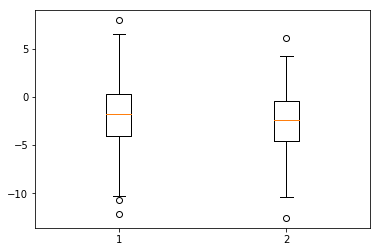

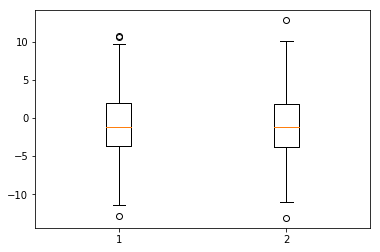

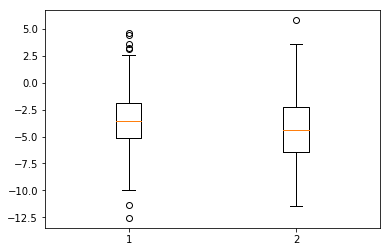

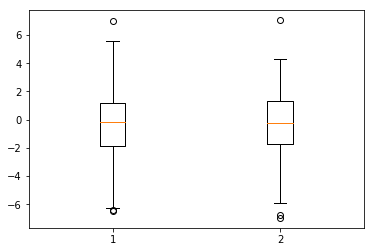

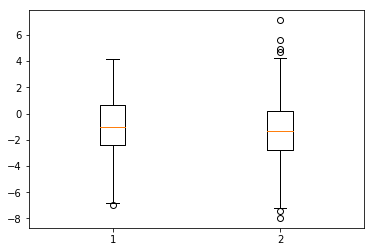

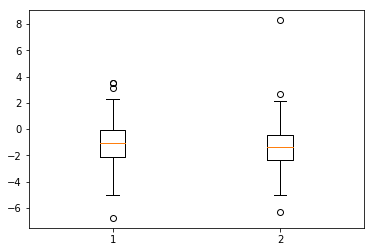

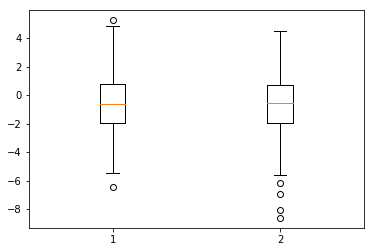

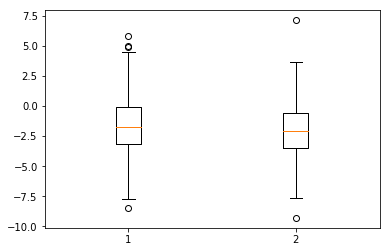

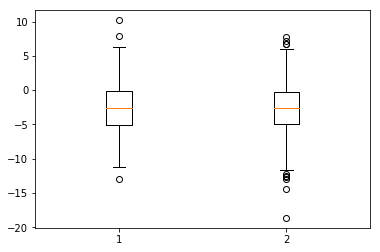

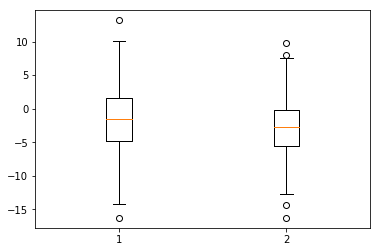

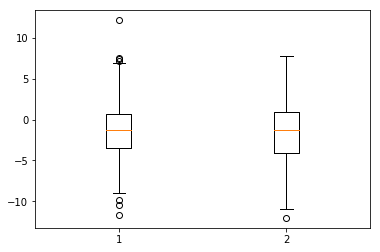

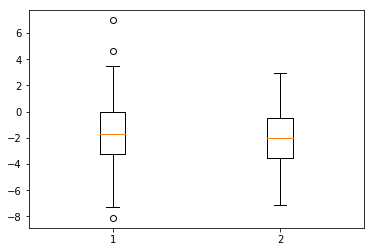

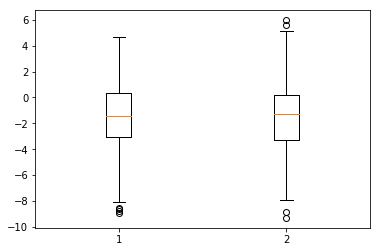

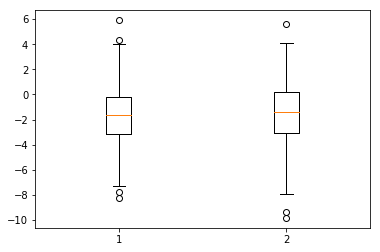

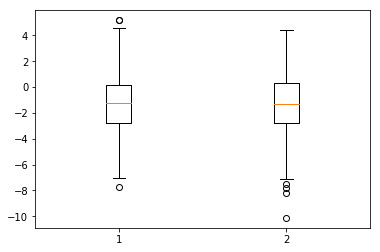

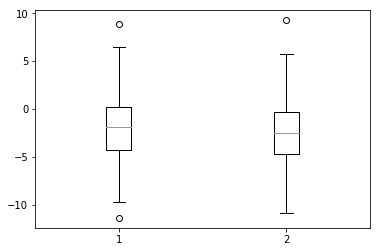

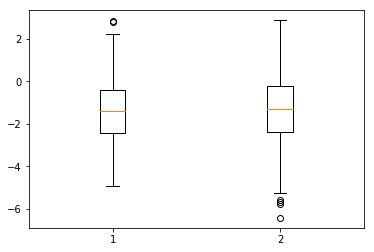

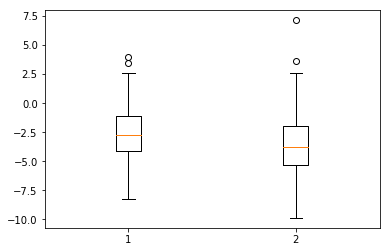

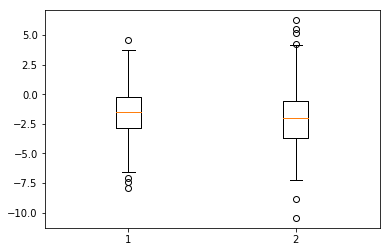

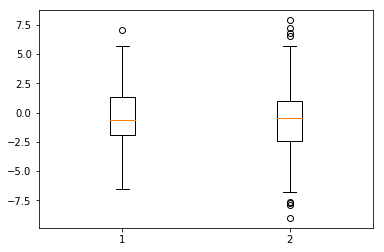

In [347]:
#roi = [17,18,19,20,21,26,27,28,29,30]
roi = np.arange(59)
for r in roi:
    print('Selected electrode : %s' % subjdata.iso.deviant.label[r])
    

#### TIME WINDOW 
timevecall = (subjdata.iso.deviant.time[0])

### index 150 = stimulus onset 

timewin = np.arange(190,206)

print('Time window : %0.4f to %0.4f ms ' % (timevecall[timewin[0]],timevecall[timewin[-1]]))



for filename in listprobands:
    matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/probands/%s'%filename

    subjdata = sio.loadmat(matfile,variable_names=filename[:-8],struct_as_record = False,squeeze_me=True)[filename[:-8]]

    ### Load and prepare data 

    y = y_temporal(subjdata)
    X = build_X(subjdata,timewin,roi).mean(axis=1)
    
    plt.boxplot([X[y==1],X[y==3]])
    plt.show()

Frontal (left: AF7, AF3, F9, F7, F5, F3; right: AF8, AF4, F10, F8, F6, F4) central (left: T7, C5, C3, TP7, CP5, CP3; right: T8, C6, C4, TP8, CP6, CP4), and parietal (left: P7, P5, P3, PO7, PO3, O1; right: P8, P6, P4, PO8, PO4, O2)

 P50: 46–66 ms and N100: 80–110 ms